In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d birdy654/eeg-brainwave-dataset-feeling-emotions

 42% 5.00M/11.9M [00:00<00:00, 39.1MB/s]
100% 11.9M/11.9M [00:00<00:00, 58.4MB/s]


In [ ]:
!ls -lr

total 12216
drwxr-xr-x 1 root root     4096 May  6 13:44 sample_data
-rw-r--r-- 1 root root       68 Jun  2 05:48 kaggle.json
-rw-r--r-- 1 root root 12498935 Jun  2 05:48 eeg-brainwave-dataset-feeling-emotions.zip


In [ ]:
!unzip eeg-brainwave-dataset-feeling-emotions.zip

Archive:  eeg-brainwave-dataset-feeling-emotions.zip
  inflating: emotions.csv            


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv('/content/emotions.csv')

In [ ]:
df.head()


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.60,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.00,-185.00,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.53,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.70,40.70,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.00,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.80,-48.80,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.9,27.7,15.70,30.7,-142.0,20.7,22.8,13.60,32.2,-135.0,21.2,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.83,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.9,-5.08,-5.08,-61.9,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.0,22.9,59.40,26.7,60.3,64.7,26.9,32.30,30.1,33.6,31.6,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.60,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.9,-7.25,-7.25,15.9,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


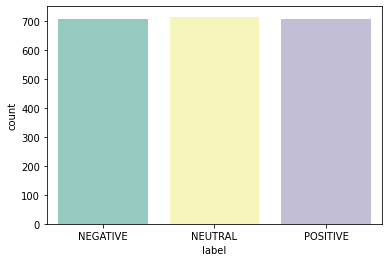

In [ ]:
import seaborn as sns
sns.countplot(x='label', data=df, palette="Set3")

In [ ]:
df.isnull().sum()

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

So we have no null values


In [ ]:
encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
df_encoded = df.replace(encode)

print(df_encoded.head())

   # mean_0_a  mean_1_a  mean_2_a  ...  fft_748_b  fft_749_b  label
0        4.62      30.3    -356.0  ...    -162.00     280.00      2
1       28.80      33.1      32.0  ...     -31.60       2.57      0
2        8.90      29.4    -416.0  ...    -148.00     281.00      1
3       14.90      31.6    -143.0  ...       9.53     -12.40      1
4       28.30      31.3      45.2  ...      23.90     -17.60      0

[5 rows x 2549 columns]


In [ ]:
print(df_encoded['label'].value_counts())

0    716
1    708
2    708
Name: label, dtype: int64


In [ ]:
df_encoded.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.60,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.00,-185.00,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,2
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.53,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.70,40.70,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,0
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.00,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.80,-48.80,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,1
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.9,27.7,15.70,30.7,-142.0,20.7,22.8,13.60,32.2,-135.0,21.2,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.83,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.9,-5.08,-5.08,-61.9,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,1
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.0,22.9,59.40,26.7,60.3,64.7,26.9,32.30,30.1,33.6,31.6,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.60,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.9,-7.25,-7.25,15.9,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,0


In [ ]:
x=df_encoded.drop(["label"]  ,axis=1)
x.shape

(2132, 2548)

In [ ]:
y = df_encoded.loc[:,'label'].values
y.shape

(2132,)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],1,x.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0],1,x.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

model = Sequential()
model.add(LSTM(64, input_shape=(1,2548),activation="relu",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             668928    
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 681,443
Trainable params: 681,443
Non-trainable params: 0
_________________________________________________________________


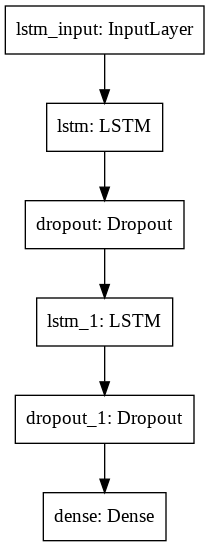

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
history = model.fit(x_train, y_train, epochs = 100, validation_data= (x_test, y_test))
score, acc = model.evaluate(x_test, y_test)

Epoch 1/100
54/54 [==============================] - 3s 15ms/step - loss: 0.4986 - accuracy: 0.8411 - val_loss: 0.3308 - val_accuracy: 0.9063
Epoch 2/100
54/54 [==============================] - 0s 9ms/step - loss: 0.2771 - accuracy: 0.9273 - val_loss: 0.2517 - val_accuracy: 0.9251
Epoch 3/100
54/54 [==============================] - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9437 - val_loss: 0.2366 - val_accuracy: 0.9180
Epoch 4/100
54/54 [==============================] - 0s 8ms/step - loss: 0.1926 - accuracy: 0.9413 - val_loss: 0.2186 - val_accuracy: 0.9251
Epoch 5/100
54/54 [==============================] - 0s 8ms/step - loss: 0.1683 - accuracy: 0.9507 - val_loss: 0.1945 - val_accuracy: 0.9297
Epoch 6/100
54/54 [==============================] - 0s 8ms/step - loss: 0.1341 - accuracy: 0.9613 - val_loss: 0.1809 - val_accuracy: 0.9344
Epoch 7/100
54/54 [==============================] - 0s 8ms/step - loss: 0.1263 - accuracy: 0.9648 - val_loss: 0.1567 - val_accuracy: 0.9485
Epoch 8/100


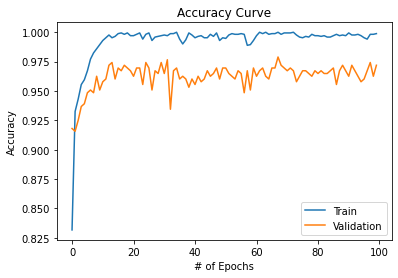

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('# of Epochs')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

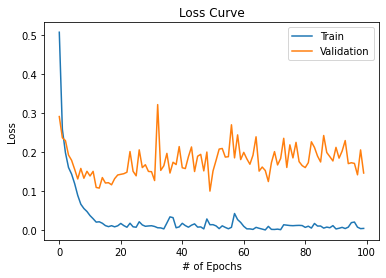

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('# of Epochs')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
model.save("eeg.h5")